# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [98]:
import sys
print(sys.version)

3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:49:36) [Clang 16.0.6 ]


In [99]:
%pip install tensorflow librosa numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


## 1.2 Load Dependencies

In [100]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import librosa
import numpy as np

print("TensorFlow version:", tf.__version__)
print("Librosa version:", librosa.__version__)
print("✅ Using librosa for audio processing (TensorFlow-IO replacement)")


TensorFlow version: 2.15.0
Librosa version: 0.11.0
✅ Using librosa for audio processing (TensorFlow-IO replacement)


# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [101]:
CAPUCHIN_FILE = os.path.join('archive', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('archive', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-1.wav')

## 2.2 Build Dataloading Function

In [102]:
def load_wav_16k_mono(filename):
    # Use librosa to load and resample audio to 16kHz mono
    wav, _ = librosa.load(filename, sr=16000, mono=True)
    return tf.convert_to_tensor(wav, dtype=tf.float32)

def load_wav_16k_mono_wrapper(filename):
    # This wrapper function handles tensor conversion for tf.py_function
    # Handle different input types that tf.py_function might pass
    
    # Convert tensor to numpy if needed
    if hasattr(filename, 'numpy'):
        filename = filename.numpy()
    
    # Handle numpy array (scalar)
    if hasattr(filename, 'item'):
        filename = filename.item()
    
    # Convert bytes to string
    if isinstance(filename, bytes):
        filename = filename.decode('utf-8')
    
    # Ensure it's a string
    if not isinstance(filename, str):
        filename = str(filename)
    
    print(f"Loading file: {filename}")  # Debug print to see what we're getting
    
    # Use librosa to load and resample audio to 16kHz mono
    wav, _ = librosa.load(filename, sr=16000, mono=True)
    return wav.astype(np.float32)

## 2.3 Plot Wave

In [103]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

In [104]:
print(wave)

print(f'len(wave): {len(wave)}')
#print the shape of the waves
print(wave.shape)
print(nwave.shape)
#The shape of the wave represents the number of samples in the wave.
#So essentially, the shape of the wave is the number of samples in the wave.

tf.Tensor(
[-0.05156644  0.10698243  0.33992094 ...  0.04074289 -0.00256476
 -0.02162626], shape=(48000,), dtype=float32)
len(wave): 48000
(48000,)
(48929,)


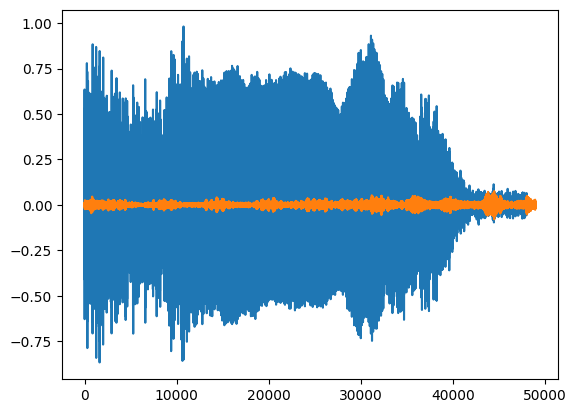

In [105]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [106]:
POS = os.path.join('archive', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('archive', 'Parsed_Not_Capuchinbird_Clips')

## 3.2 Create Tensorflow Datasets

In [107]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

#print the first 5 files in the pos dataset
for file in pos.take(5):
    print(file)

#print the first 5 files in the neg dataset
for file in neg.take(5):
    print(file)

#print the number of files in the pos dataset

tf.Tensor(b'archive/Parsed_Capuchinbird_Clips/XC495697-4.wav', shape=(), dtype=string)
tf.Tensor(b'archive/Parsed_Capuchinbird_Clips/XC79965-6.wav', shape=(), dtype=string)
tf.Tensor(b'archive/Parsed_Capuchinbird_Clips/XC22397-6.wav', shape=(), dtype=string)
tf.Tensor(b'archive/Parsed_Capuchinbird_Clips/XC201990-0.wav', shape=(), dtype=string)
tf.Tensor(b'archive/Parsed_Capuchinbird_Clips/XC9892-0.wav', shape=(), dtype=string)
tf.Tensor(b'archive/Parsed_Not_Capuchinbird_Clips/tawny-owl-sounds-6.wav', shape=(), dtype=string)
tf.Tensor(b'archive/Parsed_Not_Capuchinbird_Clips/cricket-sounds-for-sleep-19.wav', shape=(), dtype=string)
tf.Tensor(b'archive/Parsed_Not_Capuchinbird_Clips/rain-thunder-and-crickets-sound-effect-12.wav', shape=(), dtype=string)
tf.Tensor(b'archive/Parsed_Not_Capuchinbird_Clips/crickets-sound-effect-2.wav', shape=(), dtype=string)
tf.Tensor(b'archive/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-24.wav', shape=(), dtype=string)


## 3.3 Add labels and Combine Positive and Negative Samples

In [108]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [109]:
data.shuffle(1000).as_numpy_iterator().next()

(b'archive/Parsed_Not_Capuchinbird_Clips/robin-chirping-3.wav', 0.0)

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [110]:
lengths = []
for file in os.listdir(os.path.join('archive', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('archive', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [111]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [112]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [113]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [114]:
def preprocess(file_path, label): 
    # Always use tf.py_function for dataset operations, but handle the input properly
    wav = tf.py_function(load_wav_16k_mono_wrapper, [file_path], tf.float32)
    wav.set_shape([None])  # Set the shape since tf.py_function doesn't infer it
    
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [115]:
wav = load_wav_16k_mono(CAPUCHIN_FILE)
wav = wav[:48000]
zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
wav = tf.concat([zero_padding, wav],0)
spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
spectrogram = tf.abs(spectrogram)
spectrogram = tf.expand_dims(spectrogram, axis=2)
spectrogram

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[3.5203621e-03],
        [1.1002958e-03],
        [5.7965587e-03],
        ...,
        [1.0550041e-04],
        [1.0804405e-04],
        [7.1413815e-05]],

       [[3.7337914e-03],
        [2.7837134e-03],
        [3.5480680e-03],
        ...,
        [8.4210064e-05],
        [8.4716317e-05],
        [2.4117529e-05]],

       [[2.8298497e-03],
        [1.0564867e-03],
        [9.6144537e-03],
        ...,
        [1.8241670e-04],
        [1.6115885e-04],
        [7.8260899e-05]],

       ...,

       [[3.7133694e-03],
        [6.7736302e-03],
        [1.3494569e-02],
        ...,
        [1.8310758e-04],
        [8.2181716e-05],
        [1.6213953e-04]],

       [[6.6642836e-04],
        [3.5461043e-03],
        [1.0955401e-02],
        ...,
        [4.1272497e-04],
        [1.5391820e-04],
        [5.8662146e-05]],

       [[5.1540621e-03],
        [4.5303130e-03],
        [5.7057324e-03],
        ...,
        [2.9041091

## 5.2 Test Out the Function and Viz the Spectrogram

In [116]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [117]:
spectrogram, label = preprocess(filepath, label)

Loading file: archive/Parsed_Capuchinbird_Clips/XC114132-5.wav


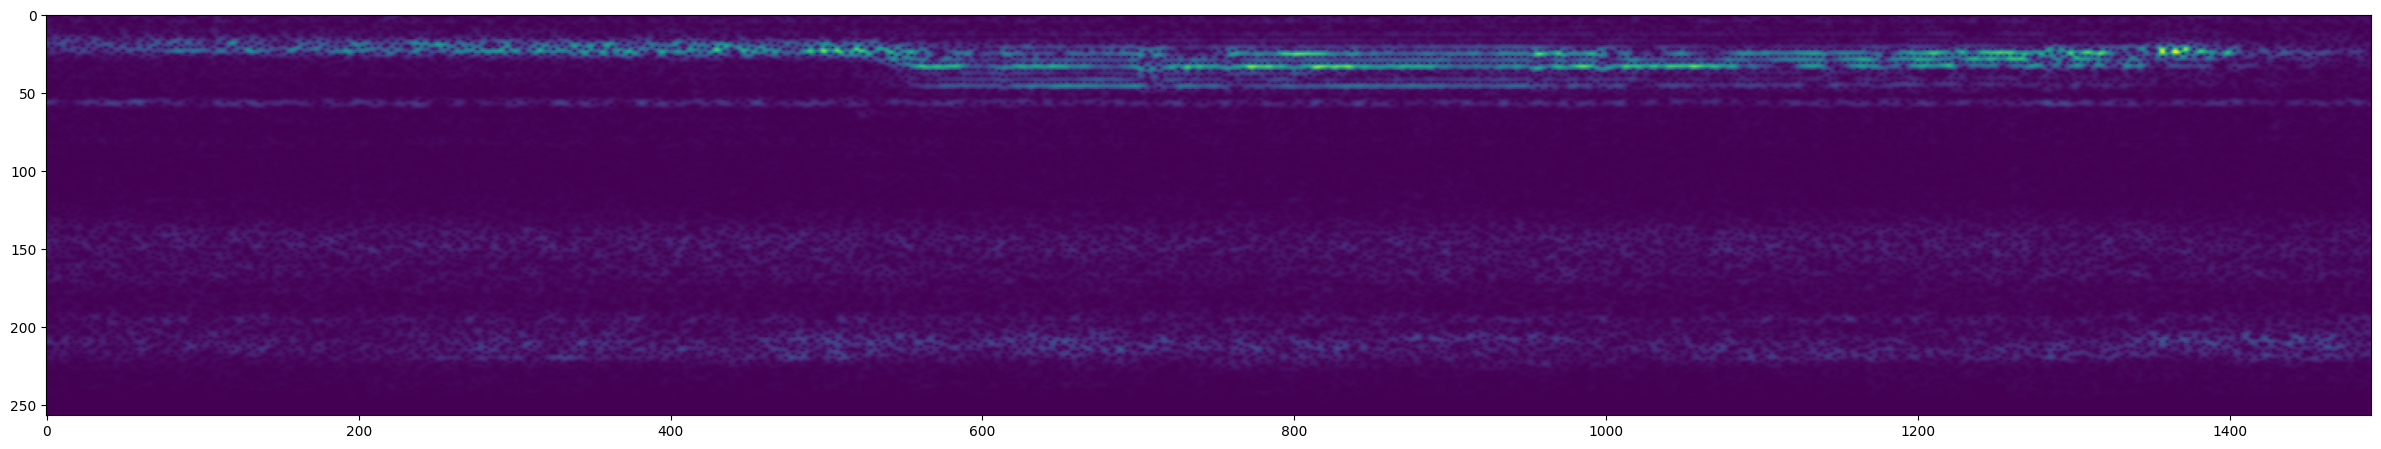

In [118]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [119]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [120]:
train = data.take(36)
test = data.skip(36).take(15)

In [121]:
print(train)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


## 6.3 Test One Batch

In [122]:
samples, labels = train.as_numpy_iterator().next()

Loading file: archive/Parsed_Capuchinbird_Clips/XC216012-7.wav
Loading file: archive/Parsed_Capuchinbird_Clips/XC216012-1.wav
Loading file: archive/Parsed_Capuchinbird_Clips/XC178168-3.wav
Loading file: archive/Parsed_Capuchinbird_Clips/XC178168-7.wav
Loading file: archive/Parsed_Capuchinbird_Clips/XC307385-3.wav
Loading file: archive/Parsed_Capuchinbird_Clips/XC27882-1.wav
Loading file: archive/Parsed_Capuchinbird_Clips/XC114132-1.wav
Loading file: archive/Parsed_Capuchinbird_Clips/XC227468-3.wav
Loading file: archive/Parsed_Capuchinbird_Clips/XC79965-8.wav
Loading file: archive/Parsed_Capuchinbird_Clips/XC216012-19.wav
Loading file: archive/Parsed_Capuchinbird_Clips/XC22397-6.wav
Loading file: archive/Parsed_Capuchinbird_Clips/XC227469-4.wav
Loading file: archive/Parsed_Capuchinbird_Clips/XC520626-2.wav
Loading file: archive/Parsed_Capuchinbird_Clips/XC79965-2.wav
Loading file: archive/Parsed_Capuchinbird_Clips/XC22397-4.wav
Loading file: archive/Parsed_Capuchinbird_Clips/XC216010-4.

In [127]:
samples.shape

(16, 1491, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [125]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

## 7.2 Build Sequential Model, Compile and View Summary

In [126]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [128]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [129]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770482865 (2.87 GB)
Trainable params: 770482865 (2.87 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 7.3 Fit Model, View Loss and KPI Plots

In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 250s 7s/step - loss: 5.9058 - recall: 0.9178 - precision: 0.8072 - val_loss: 4.5449 - val_recall: 1.0000 - val_precision: 0.9024
Epoch 2/4
36/36 [==============================] - 229s 6s/step - loss: 0.9039 - recall: 0.9739 - precision: 0.9803 - val_loss: 0.8309 - val_recall: 0.9153 - val_precision: 0.9643
Epoch 3/4
36/36 [==============================] - 242s 7s/step - loss: 0.1842 - recall: 0.9866 - precision: 0.9671 - val_loss: 0.0942 - val_recall: 0.9706 - val_precision: 1.0000
Epoch 4/4
31/36 [========================>.....] - ETA: 28s - loss: 0.0519 - recall: 0.9837 - precision: 1.0000

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)

## 8.2 Convert Logits to Classes 

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load an MP3 file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    # Use librosa to load and resample audio to 16kHz mono
    wav, _ = librosa.load(filename, sr=16000, mono=True)
    return tf.convert_to_tensor(wav, dtype=tf.float32)

In [ ]:
mp3 = os.path.join('archive', 'Forest Recordings', 'recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

## 9.4 Group Consecutive Detections

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [ ]:
results = {}
for file in os.listdir(os.path.join('archive', 'Forest Recordings')):
    FILEPATH = os.path.join('archive','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [ ]:
results

## 10.2 Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

## 10.3 Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

# 11. Export Results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])